## Plot losses

In [1]:
import os
import sys
import time
import pickle

#import numpy as np
import autograd.numpy as np
import numpy as onp
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3, linewidth=500, edgeitems=15, suppress=True)

import seaborn as sns
sns.set_palette('bright')


import matplotlib as mpl
import matplotlib.style as mplstyle

label_size = 9 
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

mplstyle.use('fast')

#from matplotlib import rc
#rc('text', usetex=False)

import utils.file_io as io

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
def get_losses(run_dir):
    obs_dir = os.path.join(run_dir, 'observables')
    if os.path.isdir(obs_dir):
        run_dir = os.path.join(run_dir, obs_dir)
    plaq_loss = io.loadz(os.path.join(run_dir, 'plaq_loss.z'))
    charge_loss = io.loadz(os.path.join(run_dir, 'charge_loss.z'))
    return plaq_loss, charge_loss

def get_charges(run_dir, fft=0):
    obs_dir = os.path.join(run_dir, 'observables')
    if os.path.isdir(obs_dir):
        run_dir = os.path.join(run_dir, obs_dir)
    return io.loadz(os.path.join(run_dir, f'charges.z'))

def get_plaqs(run_dir):
    obs_dir = os.path.join(run_dir, 'observables')
    if os.path.isdir(obs_dir):
        run_dir = os.path.join(run_dir, obs_dir)
    return io.loadz(os.path.join(run_dir, 'plaqs.z'))
    
def get_dq(q):
    q = np.insert(q, 0, q[0], axis=0)
    return np.abs(np.around(q[1:]) - np.around(q[:-1]))

In [9]:
from plotters.data_utils import therm_arr
    
def calc_tunneling_stats(charges):
    step_ax = 0  # data is appended for each step along axis 0
    num_steps = charges.shape[step_ax]
    #charges = np.insert(charges, 0, charges[0], axis=step_ax)
    charges = np.insert(charges, 0, charges[0], axis=step_ax)
    dq = np.abs(np.around(charges[1:]) - np.around(charges[:-1]))
    #dq = np.floor(np.abs(charges[1:] - charges[:-1]) + 0.5)
    tunneling_events = np.sum(dq, axis=step_ax)
    tunn_stats = {
        'tunneling_events': tunneling_events,
        'tunneling_rate': tunneling_events / num_steps,
    }
    return tunn_stats

In [10]:
def plot_setup(log_dir, filter_str):
    params = io.loadz(os.path.join(log_dir, 'params.z'))
    runs_dir = os.path.join(log_dir, 'runs_np')
    run_dirs = io.get_subdirs(runs_dir)
    
    run_dirs = [
        i for i in run_dirs if filter_str in i and 'mix_samplers' not in i
    ]
    #try:
    #    run_params = [
    #        io.loadz(os.path.join(rd, 'run_params.z')) for rd in run_dirs
    #    ]
    #    eps_arr
    #except FileNotFoundError:
    hdirs = []
    ldirs = []
    #parr = []
    leps_arr = []
    heps_arr = []
    run_params = []
    for rd in run_dirs:
        run_str = rd.split('/')[-1]
        s = run_str.split('_')

        eps_str = s[4].lstrip('eps0')
        eps = float(f'0.{eps_str}')
        #eps_arr.append(eps)
        
        beta = float(s[3].lstrip('beta')) / 10.
        #beta = [i for i in run_dirs[0].split('_') if 'beta' in i]
        #beta = float(beta[0].lstrip('beta')) / 10
        beta_str = str(beta).replace('.', '')
        #beta_arr.append(beta)
        #parr.append((beta, eps))

        rp = {
            'num_steps': int(s[0].lstrip('lf')),
            'batch_size': int(s[1].lstrip('bs')),
            'run_steps': int(s[2].lstrip('steps')),
            'eps':  float(f'0.{eps_str}'),
            'beta': float(s[3].lstrip('beta')) / 10,
            'nw': [float(i) for i in s[5].lstrip('nw')],
            'init': s[6].lstrip('init'),
        }
        run_params.append(rp)
        if 'nw000000' in rd:
            hdirs.append(rd)
            heps_arr.append(eps)
        if 'nw111111' in rd:
            ldirs.append(rd)
            leps_arr.append(eps)

    batch_size = run_params[0]['batch_size']
    #eps = run_params[0]['eps']
    
    #hmc_dir = [i for i in run_dirs if 'nw000000' in i]
    #l2hmc_dir = [i for i in run_dirs if 'nw111111' in i]
    
    
    title_str = (f"{params['time_size']}"
                 r"$\times$" + f"{params['space_size']}, "
                 r"$\beta = $" + f'{beta:.3g}, '
                 r"$N_{\mathrm{LF}} = $" + f"{params['num_steps']}, "
                 r"$N_{\mathrm{B}} = $" + f'{batch_size}')
    
    if len(np.unique(leps_arr)) + len(np.unique(heps_arr)) == 2:
        title_str += ', ' + r"$\varepsilon = $" + f'{eps:.3g}'
    
    return hdirs, heps_arr, ldirs, leps_arr, title_str



In [11]:
from plotters.plot_utils import get_title_str
from plotters.data_utils import therm_arr
from collections import namedtuple

Losses = namedtuple('Losses', ['steps', 'plaq', 'charge'])

label_size = 6 
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

c0 = 'C7'
c1 = 'C6'

def plot_pair_losses(log_dir, filter_str):
    hmc_dir, hmc_eps_arr, l2hmc_dir, l2hmc_eps_arr, title_str = plot_setup(log_dir, filter_str)
    hmc_dir = hmc_dir[0]
    l2hmc_dir = l2hmc_dir[0]
    plaq_loss_hmc, charge_loss_hmc = get_losses(hmc_dir)
    plaq_loss_l2hmc, charge_loss_l2hmc = get_losses(l2hmc_dir)
    
    charge_hmc, _ = therm_arr(charge_loss_hmc, therm_frac=0.33)
    plaq_hmc, steps_hmc = therm_arr(plaq_loss_hmc, therm_frac=0.33)

    charge_l2hmc, _ = therm_arr(charge_loss_l2hmc, therm_frac=0.33)
    plaq_l2hmc, steps_l2hmc = therm_arr(plaq_loss_l2hmc, therm_frac=0.33)

    fig, axes = plt.subplots(ncols=2, nrows=2)
    kwargs = {
        'markersize': 0.8,
        'ls': '',
        #'markeredgewidth': 0.6,
    }
    for idx in range(plaq_hmc.shape[1]):
        hmc_label = None
        l2hmc_label = None

        axes[0, 1].plot(steps_hmc, plaq_hmc[:, idx], marker='.', color=c0, label=hmc_label, **kwargs)
        axes[0, 1].plot(steps_l2hmc, plaq_l2hmc[:, idx], marker='.', alpha=0.7, color=c1, label=l2hmc_label, **kwargs)

        axes[1, 1].plot(steps_hmc, charge_hmc[:, idx], marker='.', color=c0, label=hmc_label, **kwargs)
        axes[1, 1].plot(steps_l2hmc, charge_l2hmc[:, idx], marker='.', alpha=0.7, color=c1, label=l2hmc_label, **kwargs)
        
    sns.kdeplot(plaq_hmc.flatten(), shade=True, ax=axes[0, 0], color=c0)
    sns.kdeplot(plaq_l2hmc.flatten(), shade=True, ax=axes[0, 0], color=c1)
    sns.kdeplot(charge_hmc.flatten(), shade=True, ax=axes[1, 0], color=c0, label='HMC', clip=(-5., 2.))
    sns.kdeplot(charge_l2hmc.flatten(), shade=True, ax=axes[1, 0], color=c1, label='L2HMC', clip=(-5., 2.))
    
    axes[0, 0].set_xlabel('plaq. loss', fontsize='large')
    axes[1, 0].set_xlabel('charge loss', fontsize='large')
    axes[0, 1].set_xlabel(f'step', fontsize='large')
    axes[1, 1].set_xlabel(f'step', fontsize='large')
    
    fig.suptitle(title_str, fontsize='x-large', y=1.05)
    plt.tight_layout()
    
    out_file = os.path.join(log_dir, 'figures_np', f'{filter_str}_losses.png')
    plt.savefig(out_file, dpi=400, bbox_inches='tight')
    
    losses_hmc = Losses(steps_hmc, plaq_hmc, charge_hmc)
    losses_l2hmc = Losses(steps_l2hmc, plaq_l2hmc, charge_l2hmc)
    
    return losses_hmc, losses_l2hmc, title_str

In [18]:
import arviz as az
import xarray as xr

therm_frac= 0.33
plt.rcParams.update({'axes.titlesize': 10})

def update_data(data, charges, therm_frac=0.33, include_dq=False, key='L2HMC', eps_arr=None):
    for idx, q in enumerate(charges):
        q = np.array(q)
        #q = np.around(q)
        
        dq = np.zeros_like(q)
        if include_dq:
            dq = get_dq(q)
            dq = dq.T
            dq, _ = therm_arr(dq, therm_frac)
            
        q = q.T
        q, steps = therm_arr(q, therm_frac)
        
        key_ = f'{key}, eps: {eps_arr[idx]}'
        #key = f'{key}, eps: {eps_arr[idx]}'
        #if len(np.unique(eps_arr)) == 1:
        #if len(np.unique(eps_arr)) > 1:
        #    key += f'{key}, eps: {parr[idx][1]}'
            
        if idx == 0:
            dkey = f'dQ {key_}'

        else:
            key_ = f'{key_}, run: {idx}'
            dkey = f'dQ {key_}, run: {idx}'
                
        chains = np.arange(q.shape[0])
        if key_ in data:
            key_ += ' '
            
        data[key_] = xr.DataArray(q, dims=['chain', 'draw'],
                                 coords=[chains, steps])
        if include_dq:
            for n, x in enumerate(dq):
                x += ((n + 1) * (-1)**n)
        if include_dq:
            data[dkey_] = xr.DataArray(dq, dims=['chain', 'draw'],
                                       coords=[chains, steps])
            
    return data
    
    
def plot_charges(log_dir, filter_str, fft=0, include_dq=False):
    #hmc_dir, l2hmc_dir, title_str, eps_arr = plot_setup(log_dir, filter_str)
    hdirs, heps, ldirs, leps, title_str = plot_setup(log_dir, filter_str)
    
    qhmc = [get_charges(hd, fft) for hd in hdirs]
    ql2hmc = [get_charges(ld, fft) for ld in ldirs]
    #title_str = f'top. charge,' + r"$\mathcal{Q}$, " + title_str
        
    #charges_hmc = [get_charges(hd, fft) for hd in hmc_dir]
    #charges_l2hmc = [get_charges(ld, fft) for ld in l2hmc_dir]
    
    data = {}
    data = update_data(data, ql2hmc, key='L2HMC', eps_arr=leps, include_dq=include_dq)
    data = update_data(data, qhmc, key='HMC', eps_arr=heps, include_dq=include_dq)
    
    dataset = xr.Dataset(data)
    az.plot_trace(data)#, trace_kwargs={'linewidth': 1.})
    fig = plt.gcf()
    plt.tight_layout()
    fig.suptitle(title_str, fontsize=20, y=1.05)
    out_file = os.path.join(log_dir, 'figures_np', f'{filter_str}_charges.png')
    plt.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()

In [26]:
def plot_tunneling_rates(log_dir, filter_str):
    hdirs, heps, ldirs, leps, title_str = plot_setup(log_dir, filter_str)
    qhmc = [get_charges(hd) for hd in hdirs]
    ql2hmc = [get_charges(ld) for ld in ldirs]
    dqhmc = []
    #trhmc = []
    #trl2hmc = []
    dql2hmc = []
    for qh, ql in zip(qhmc, ql2hmc):
        dqh = get_dq(qh)
        dql = get_dq(ql)
        dqhmc.append(dqh)
        dql2hmc.append(dql)

    dqhmc = np.array(dqhmc)
    dql2hmc = np.array(dql2hmc)
    
    
    fig, ax = plt.subplots()
    for dqh, epsh in zip(dqhmc, heps):
        trhmc = np.sum(dqh, axis=0) / dqh.shape[0]
        sns.kdeplot(trhmc.flatten(), shade=True, ax=ax, color='C7', label=f'HMC, eps: {epsh:.3g}')
        #sns.kdeplot(dqh.flatten(), shade=True, ax=ax, label=f'HMC, eps: {epsh:3g}')
    for dql, epsl in zip(dql2hmc, leps):
        trl2hmc = np.sum(dql, axis=0) / dql.shape[0]
        sns.kdeplot(trl2hmc.flatten(), shade=True, ax=ax, color='C6', label=f'L2HMC, eps: {epsl:.3g}')
        #sns.kdeplot(dql.flatten(), shade=True, ax=ax, label=f'L2HMC, eps: {epsl:.3g}')
        
    plt.tight_layout()
    fig.suptitle(title_str, fontsize=20, y=1.05)
    out_file = os.path.join(log_dir, 'figures_np', f'{filter_str}_dq.png')
    plt.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()

In [27]:
def get_unique_betas(log_dir):
    def _get_beta(rd):
        rs = rd.split('/')[-1].split('_')
        return rs[3]
    
    run_dirs = [
        os.path.join(log_dir, 'runs_np', i)
        for i in os.listdir(os.path.join(log_dir, 'runs_np'))
    ]
    betas = [_get_beta(rd) for rd in run_dirs]
    return np.unique(betas)
   

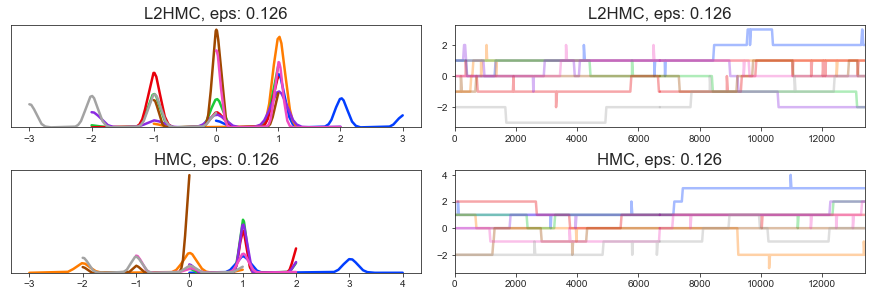

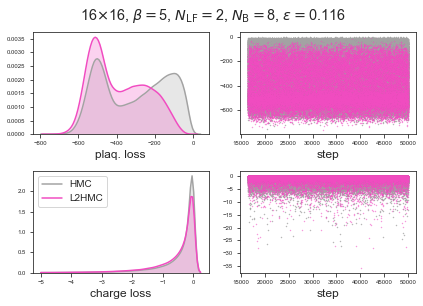

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

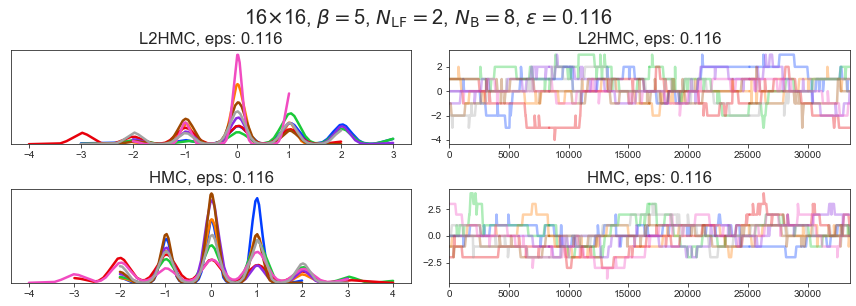

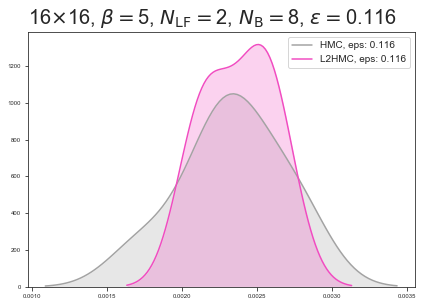

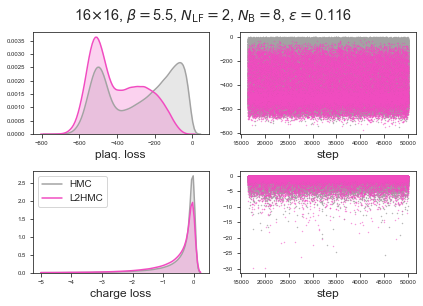

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

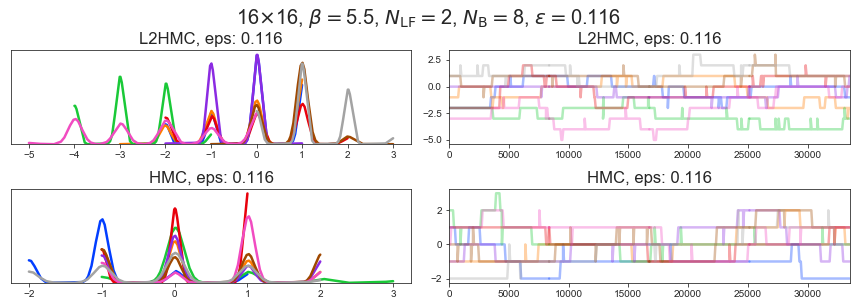

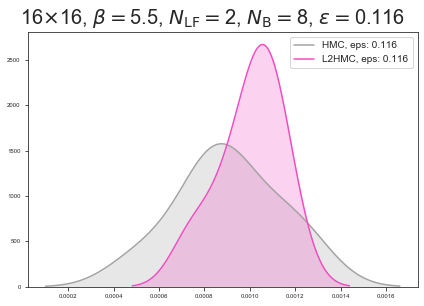

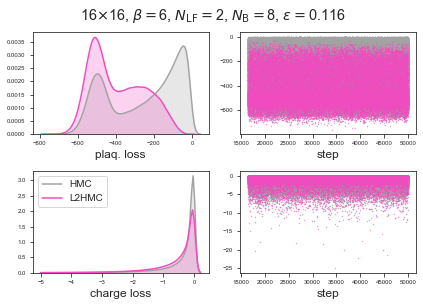

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

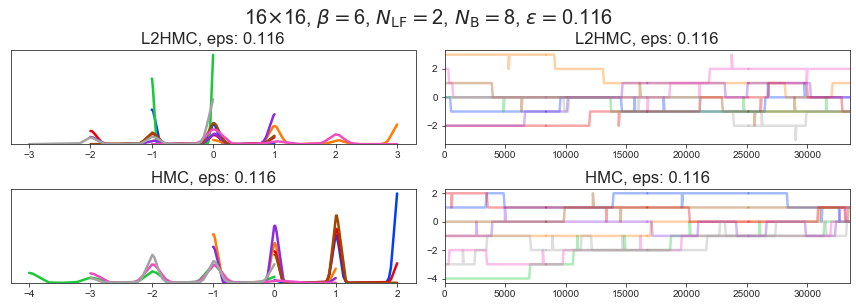

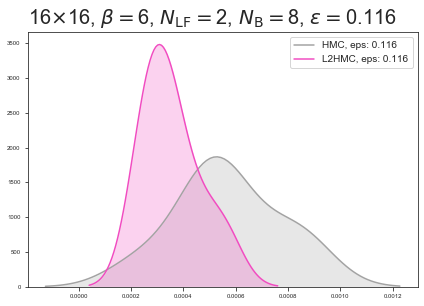

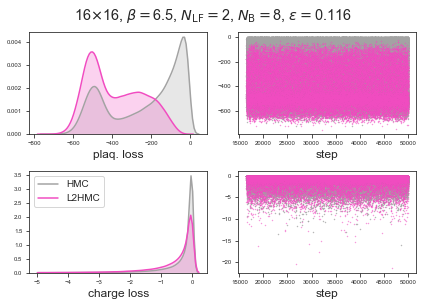

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

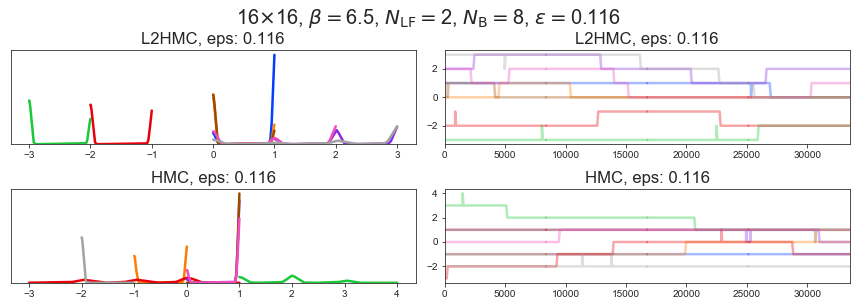

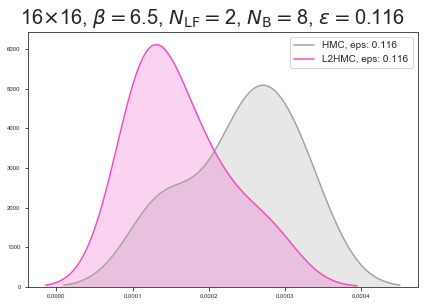

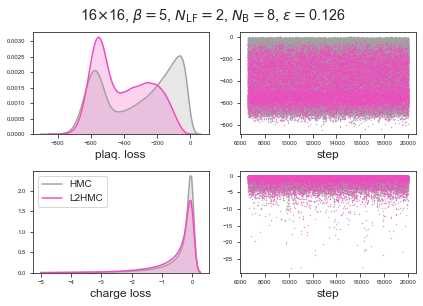

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

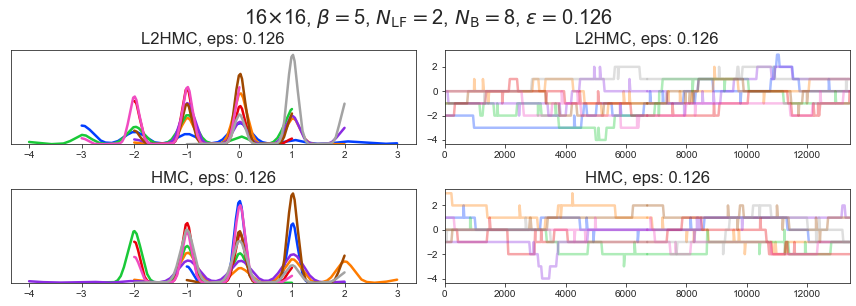

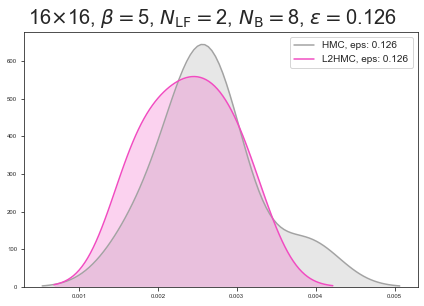

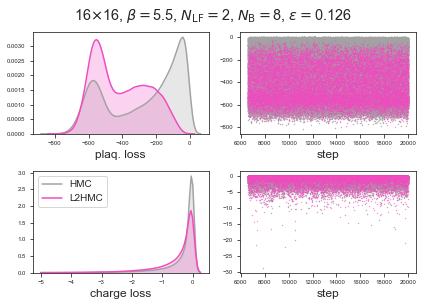

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

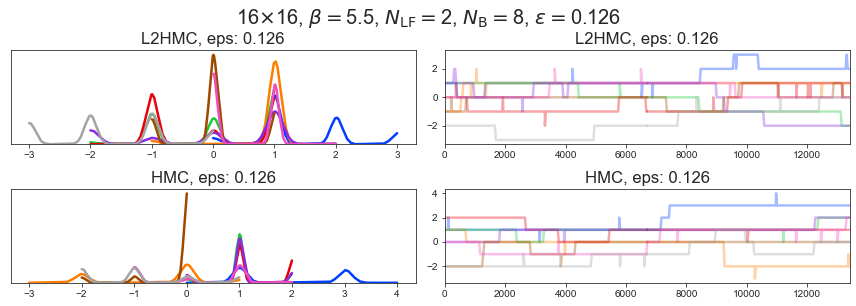

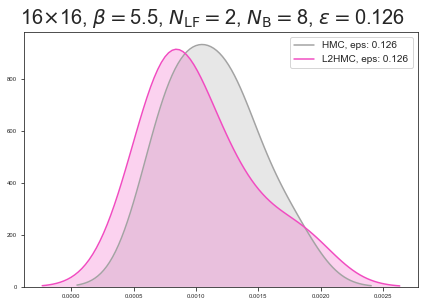

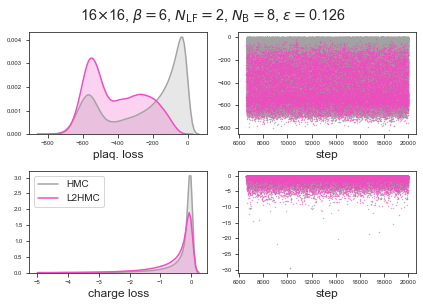

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/User

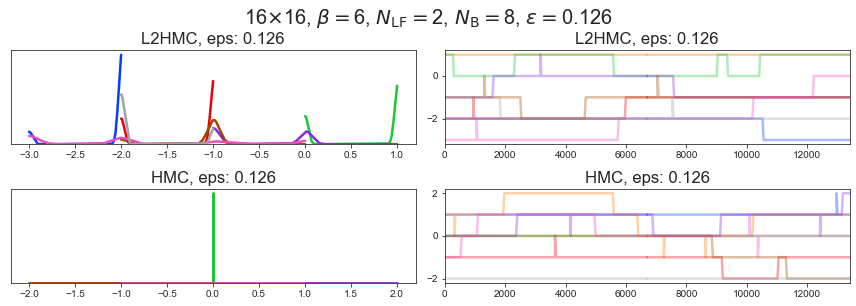

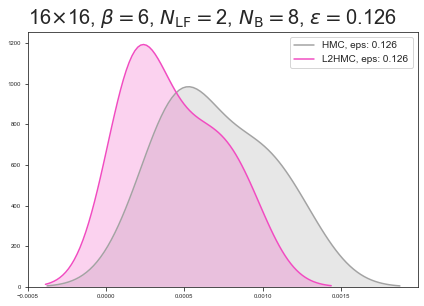

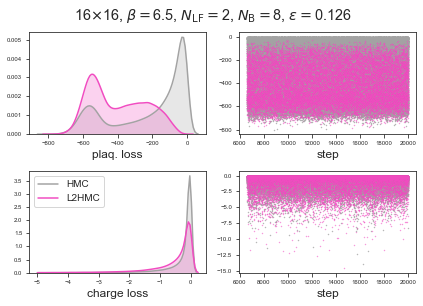

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

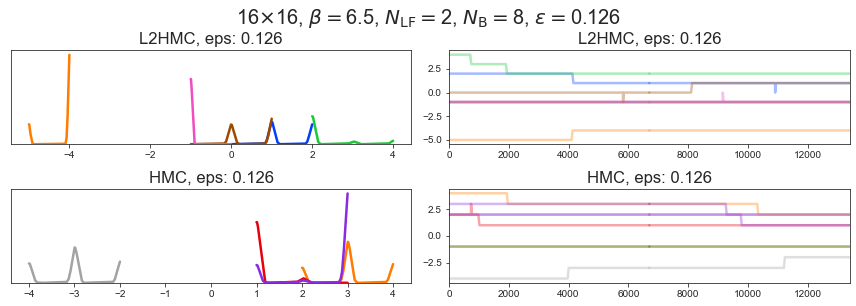

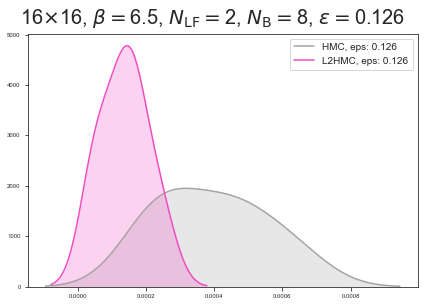

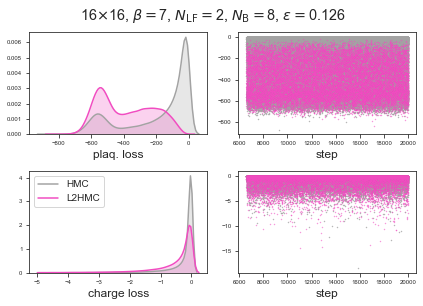

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/User

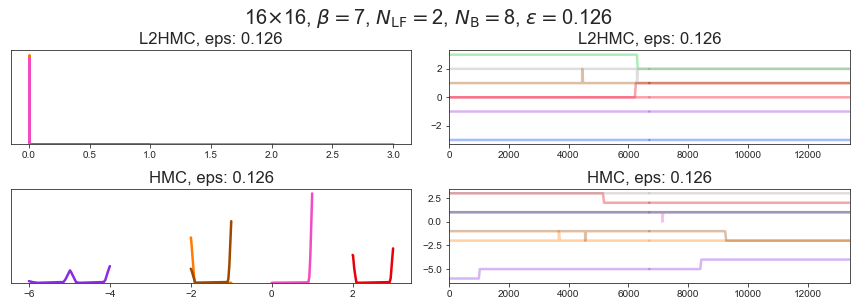

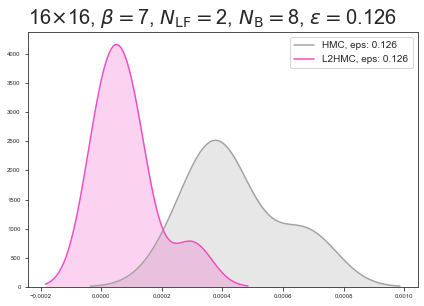

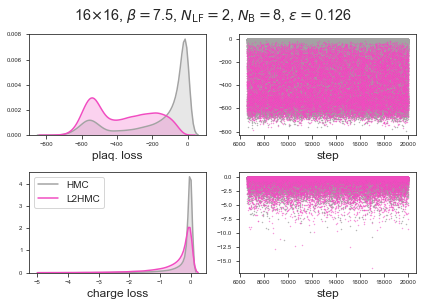

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/User

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


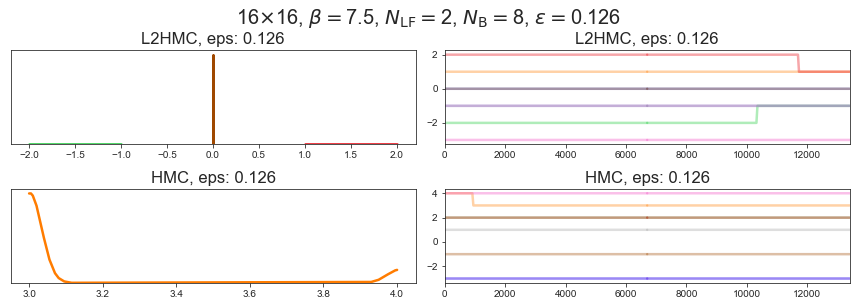

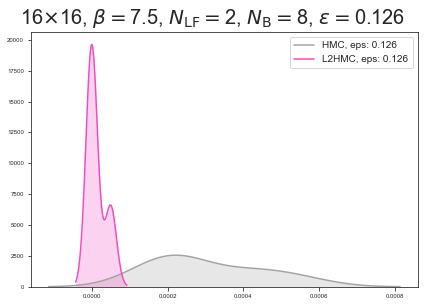

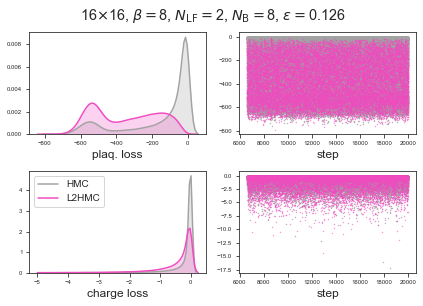

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/User

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


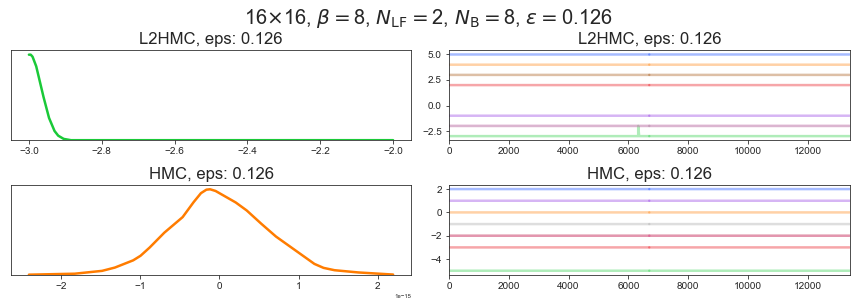

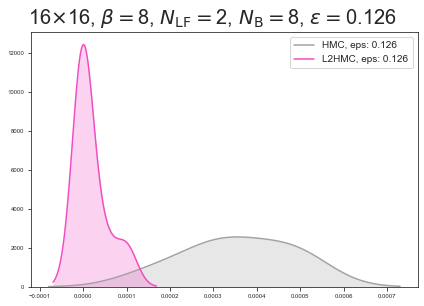

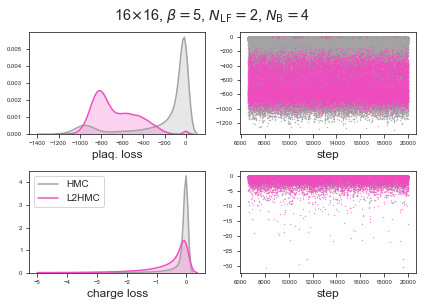

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

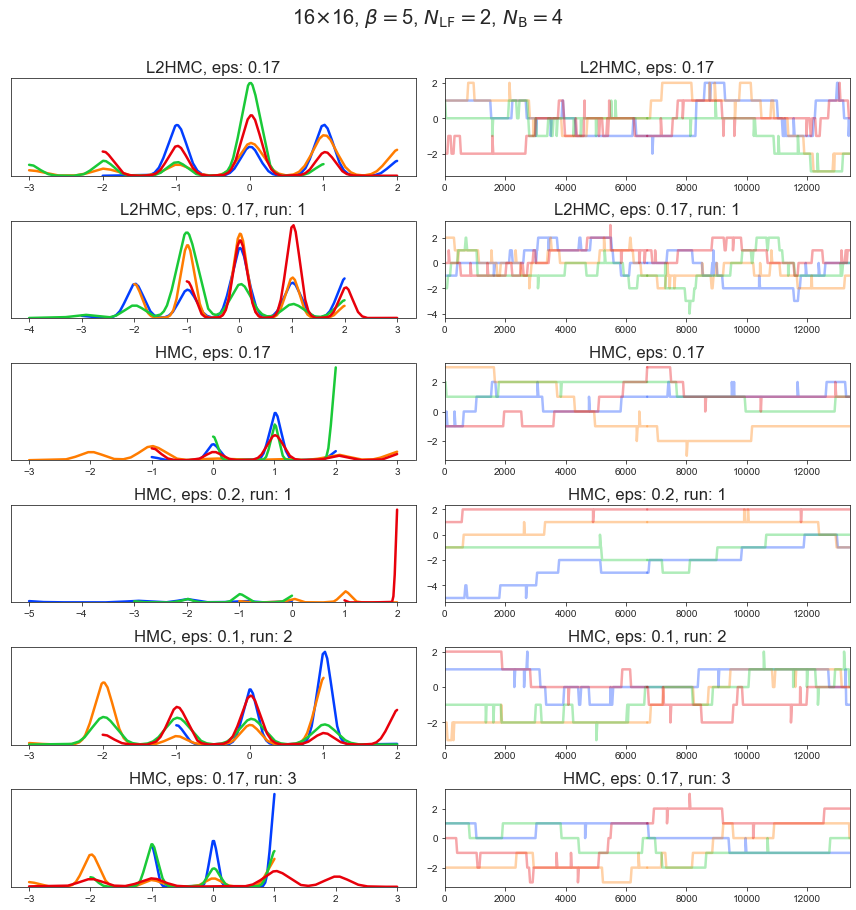

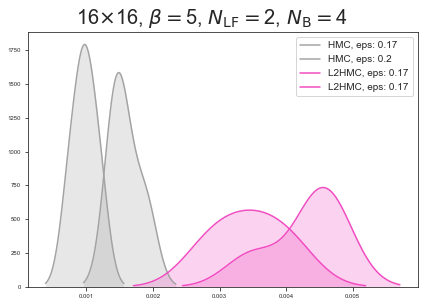

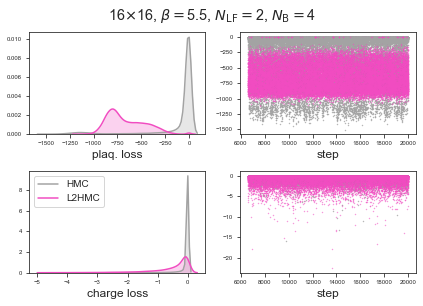

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

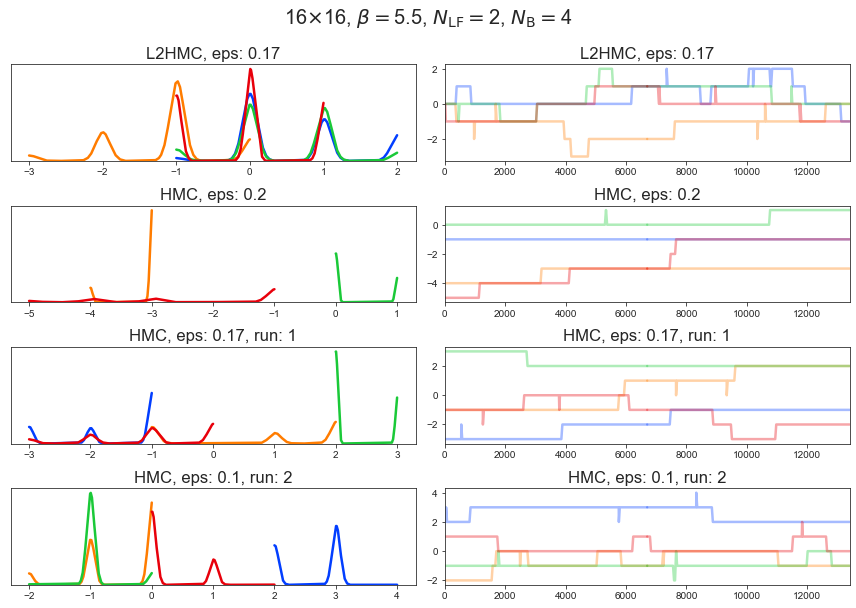

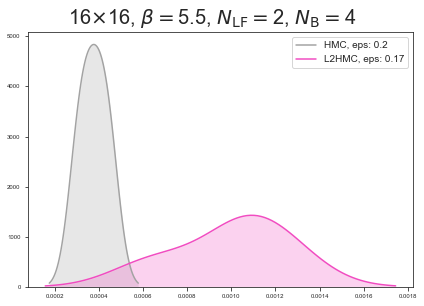

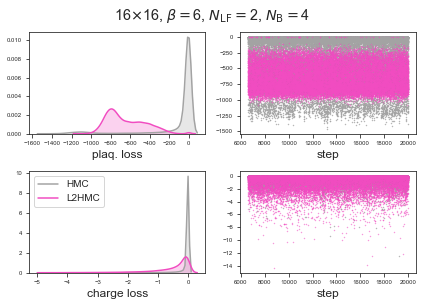

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

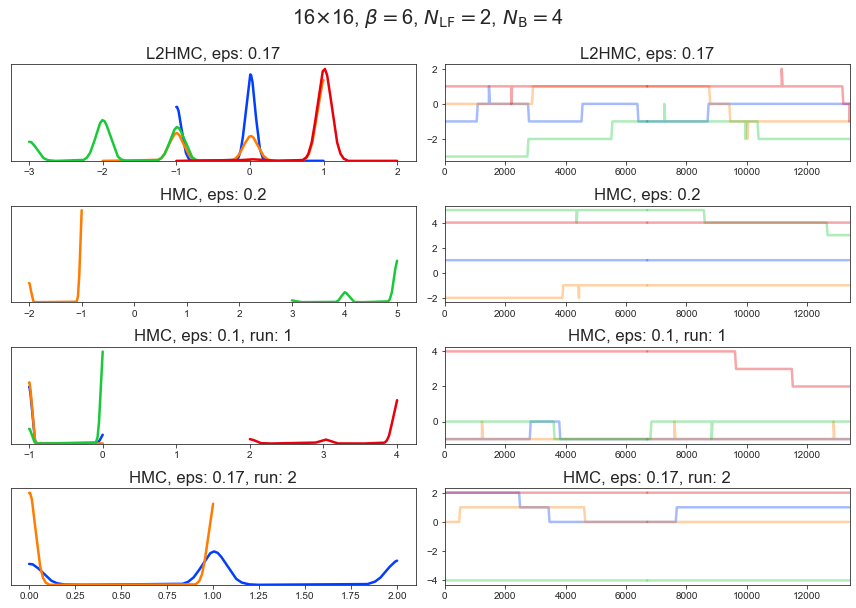

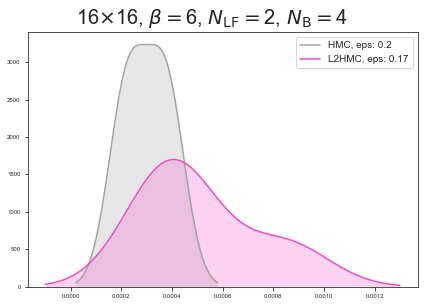

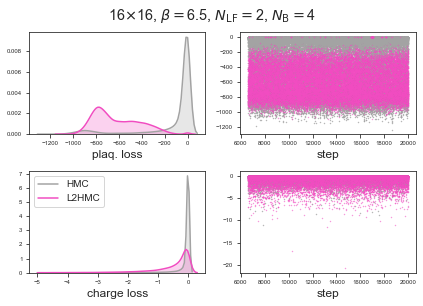

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/User

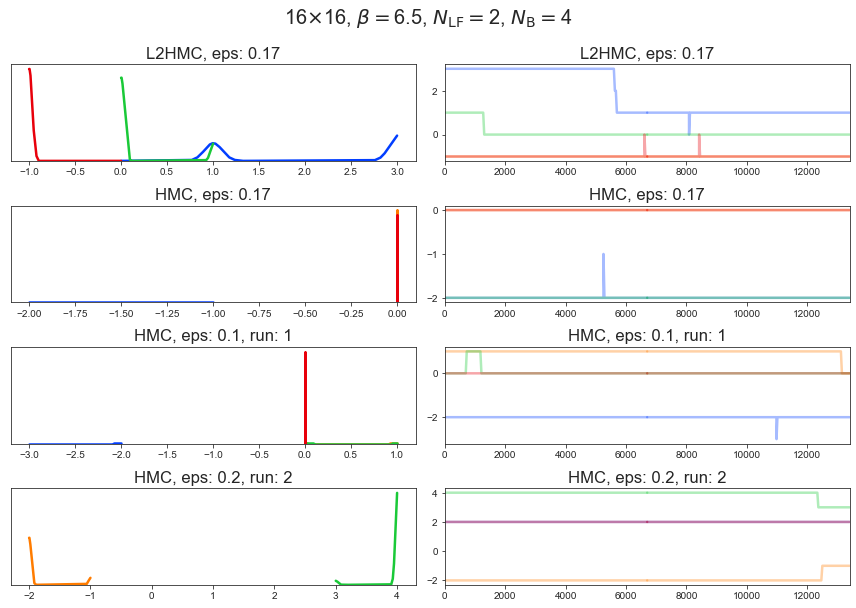

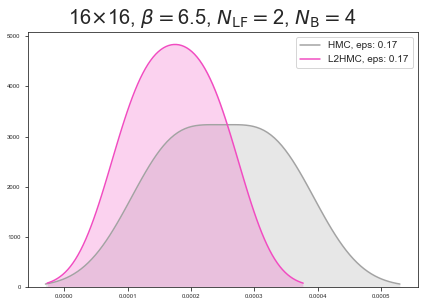

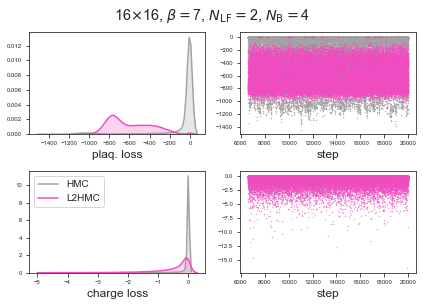

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


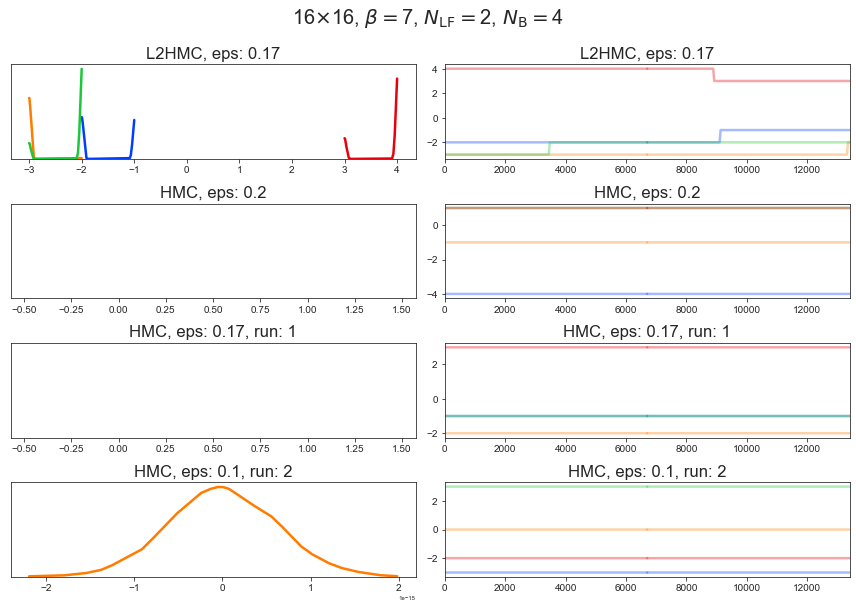

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


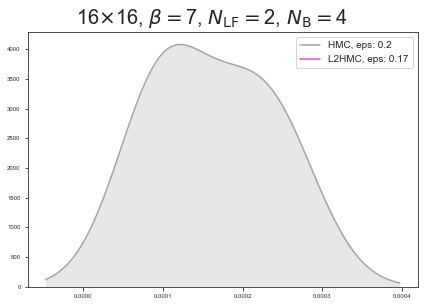

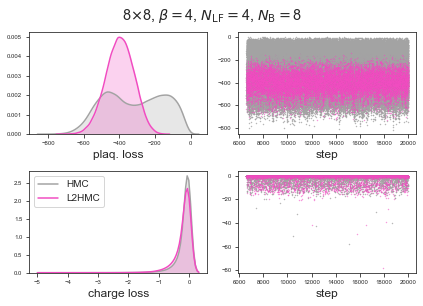

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


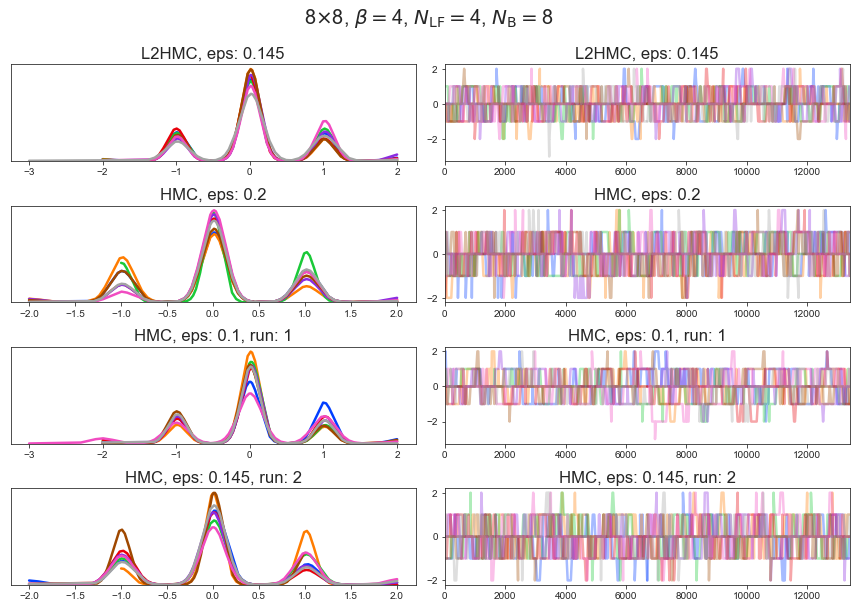

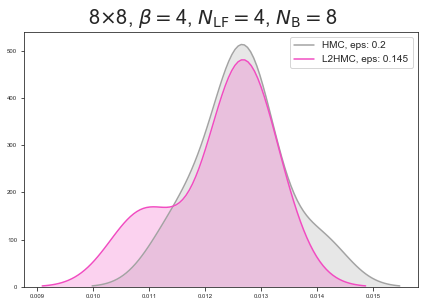

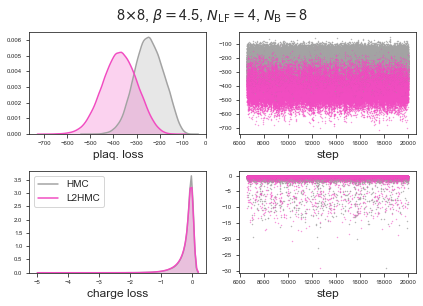

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


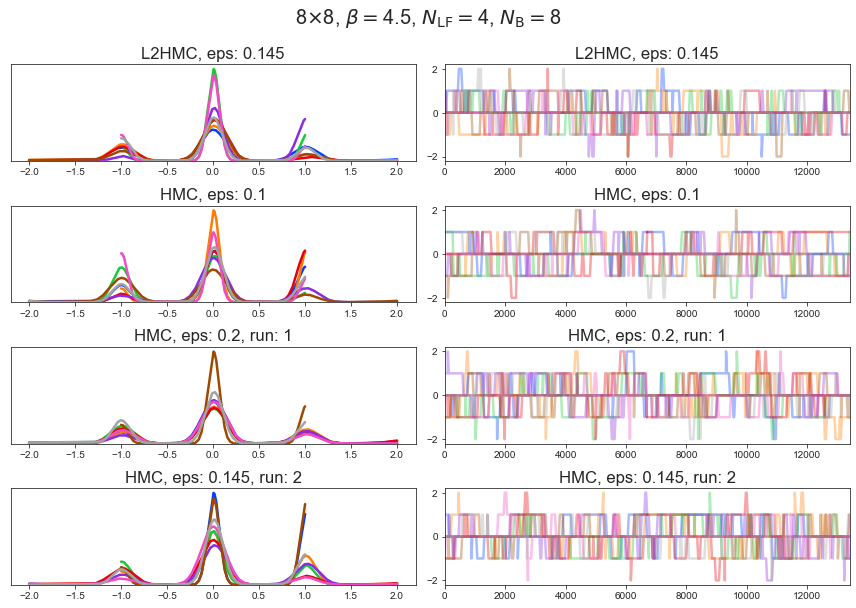

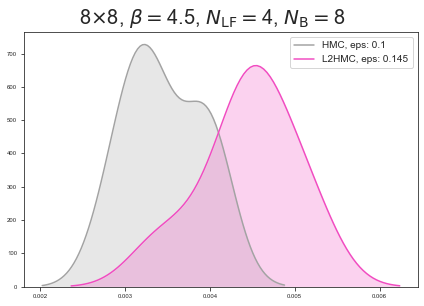

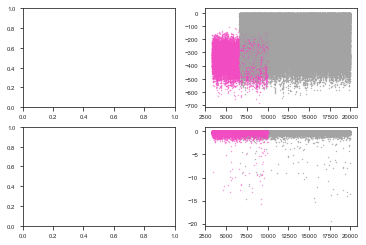

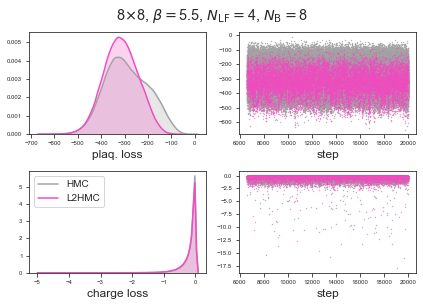

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/kdeplot.py:259: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/kdeplot.py:259: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want

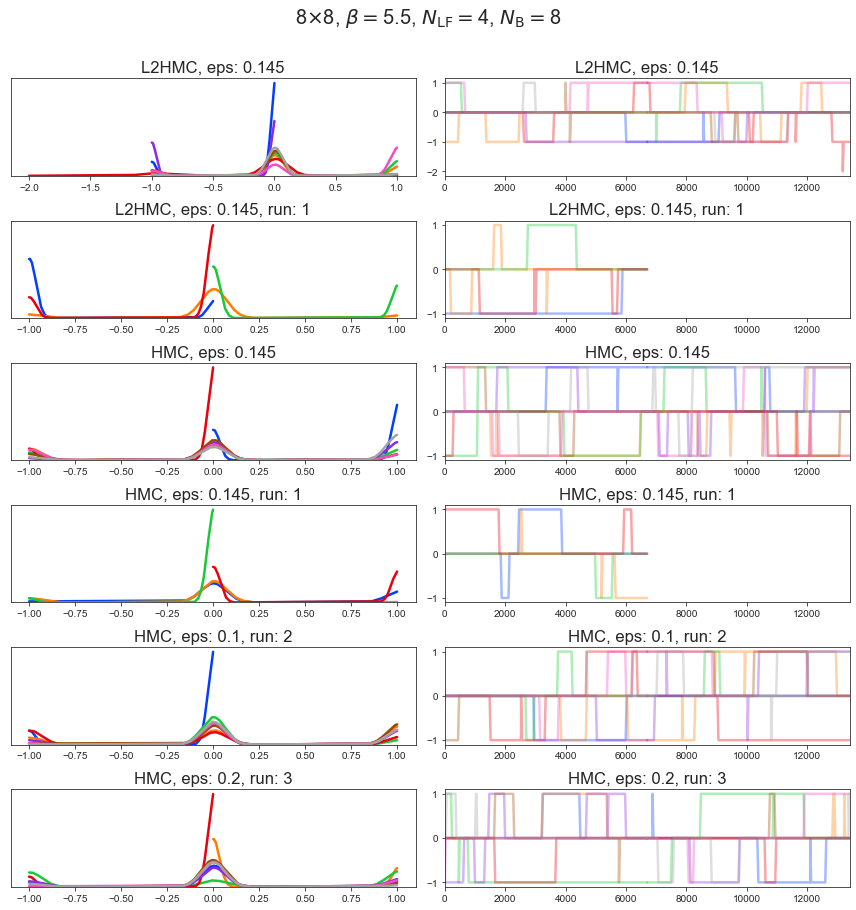

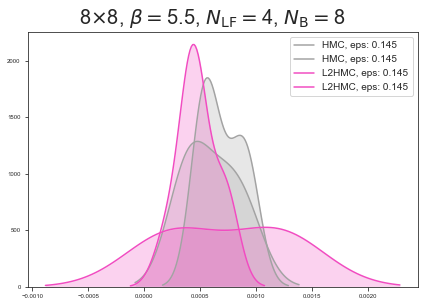

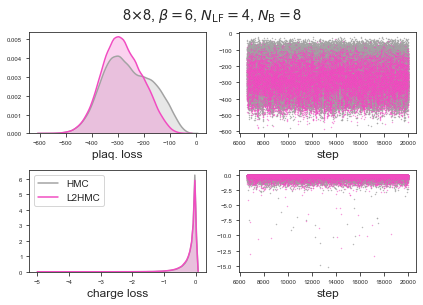

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

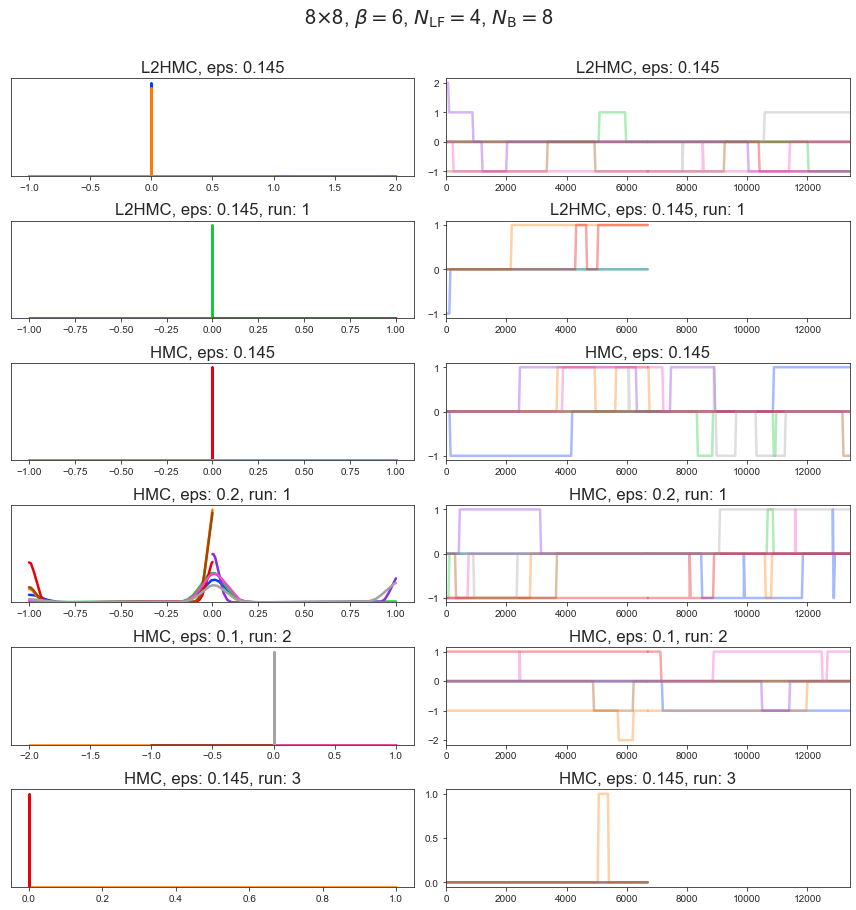

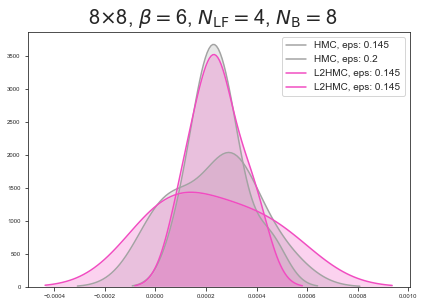

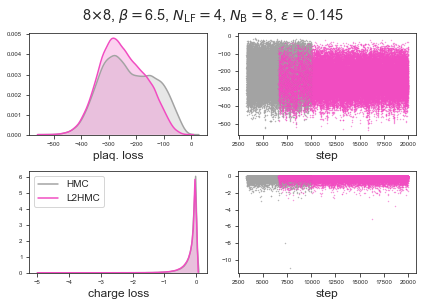

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/User

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/kdeplot.py:259: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied valu

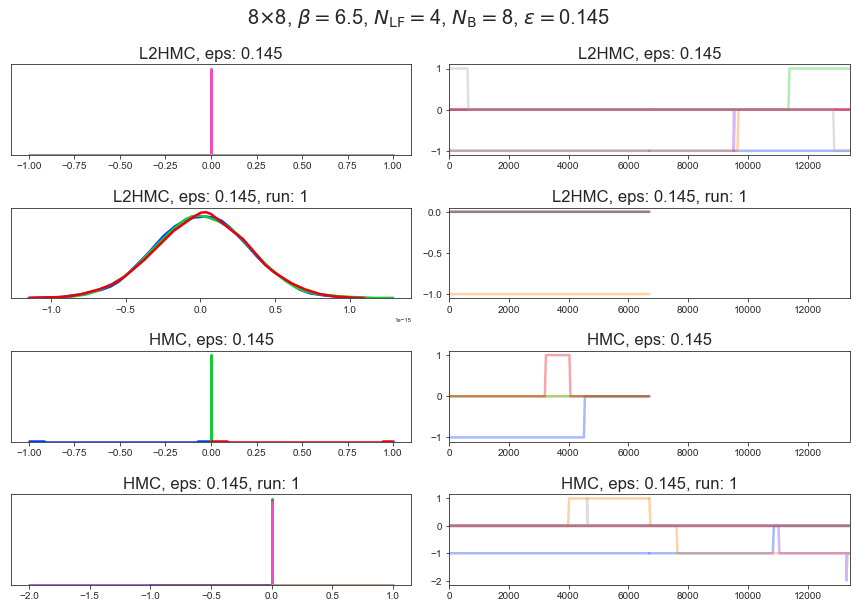

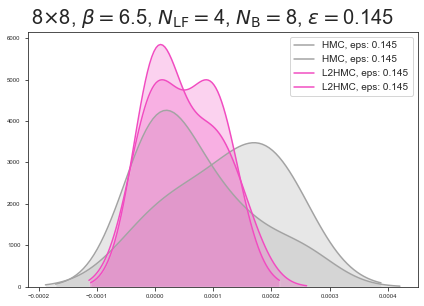

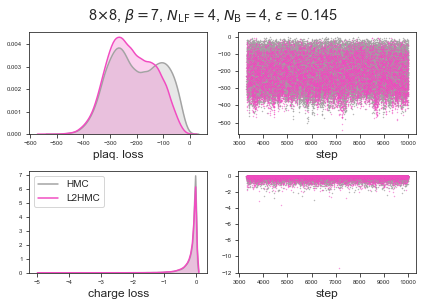

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/User

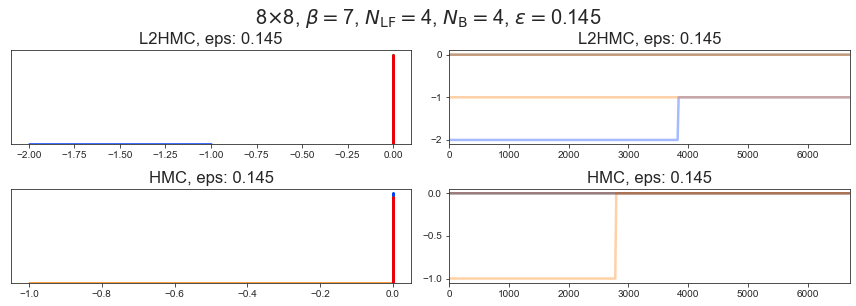

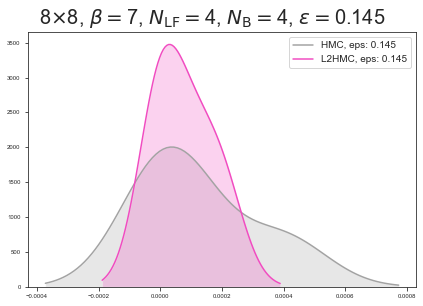

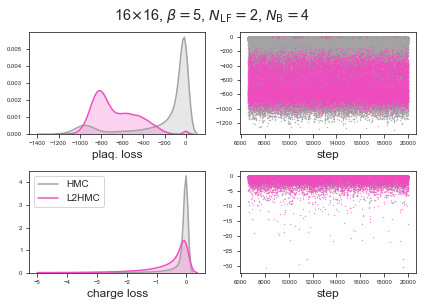

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

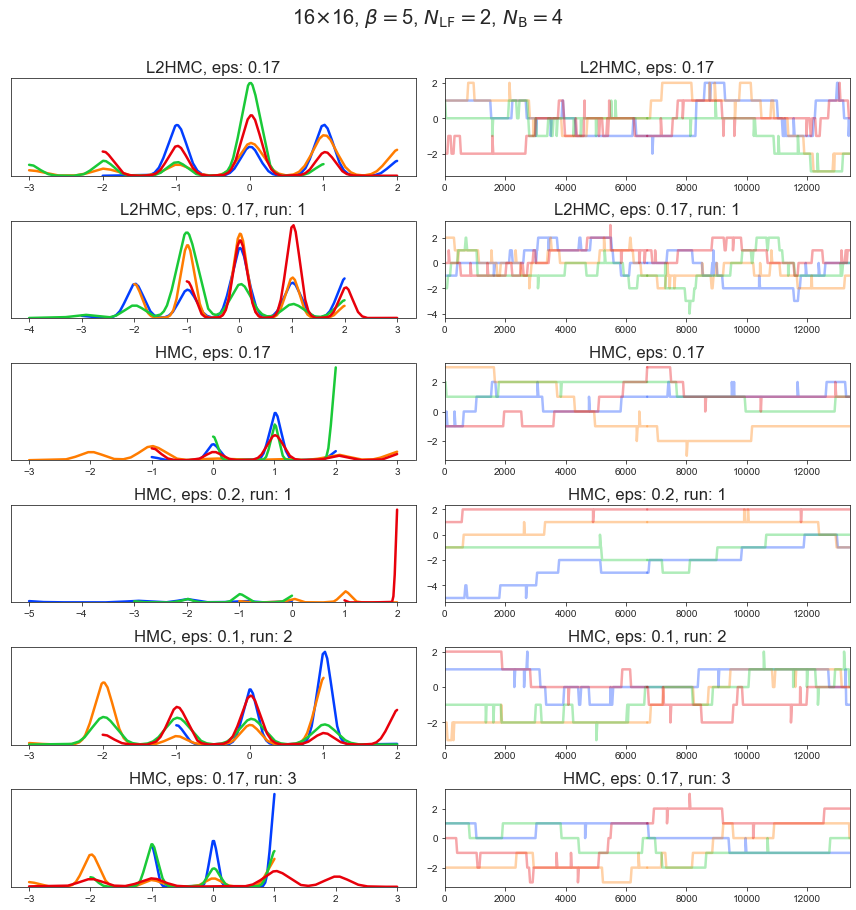

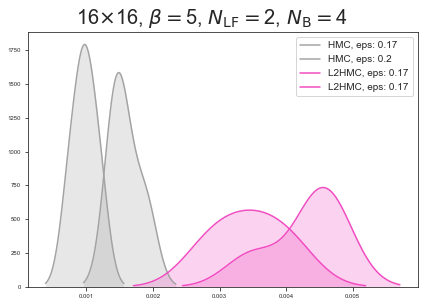

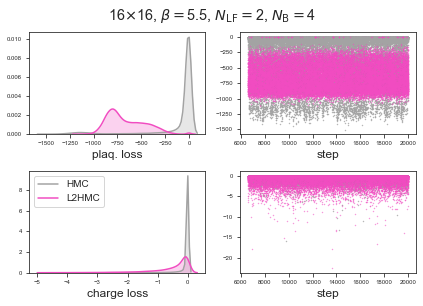

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

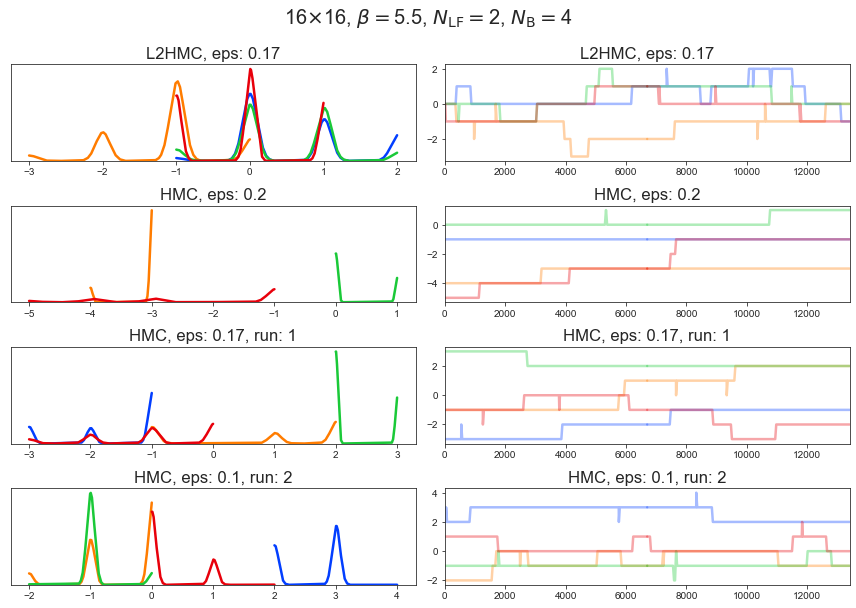

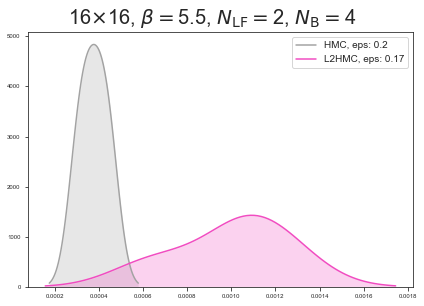

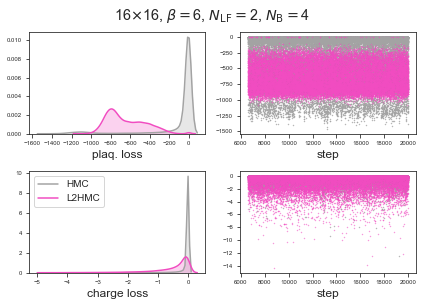

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

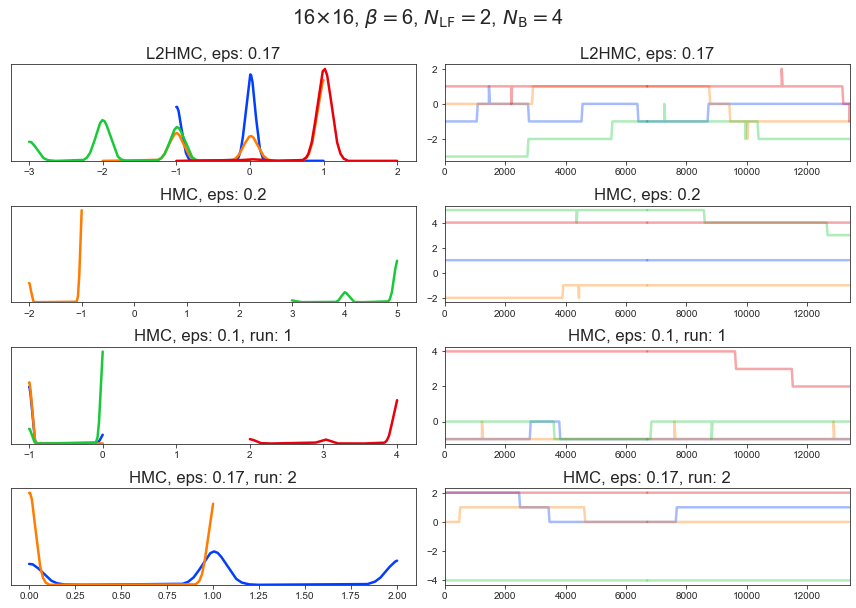

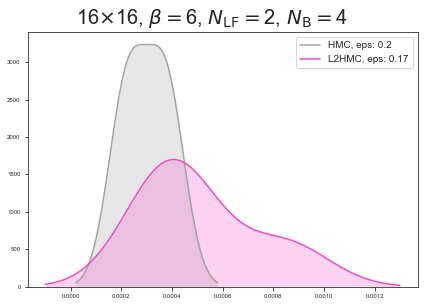

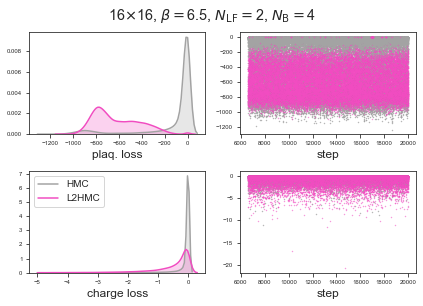

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/stats/stats_utils.py:496: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/User

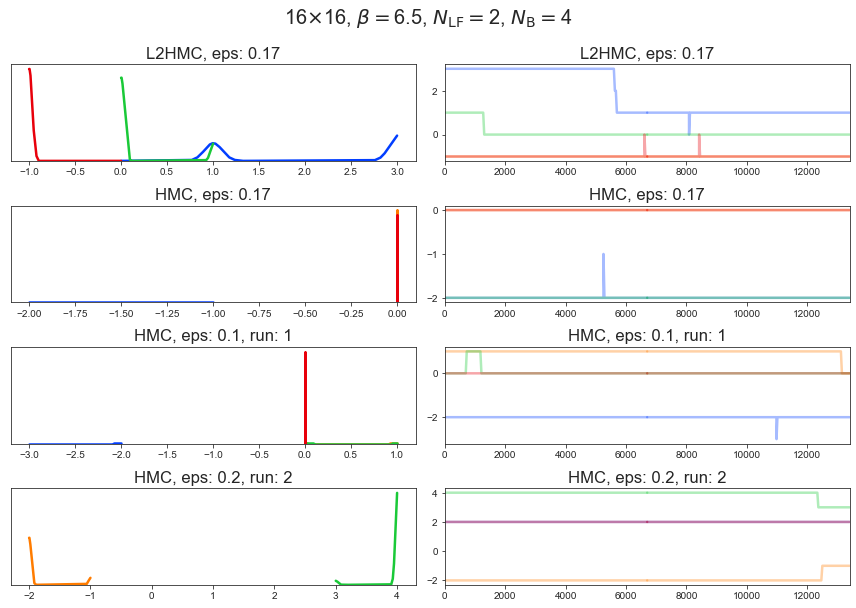

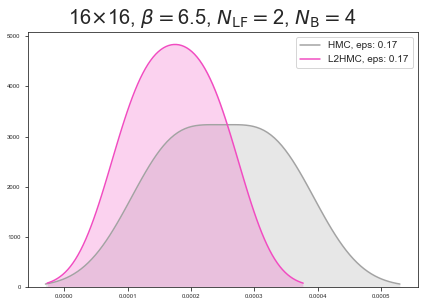

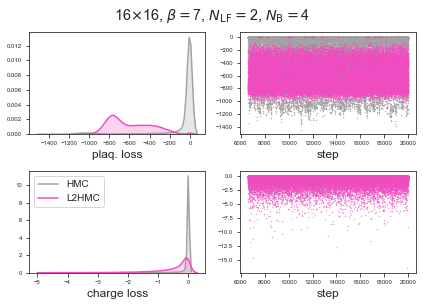

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


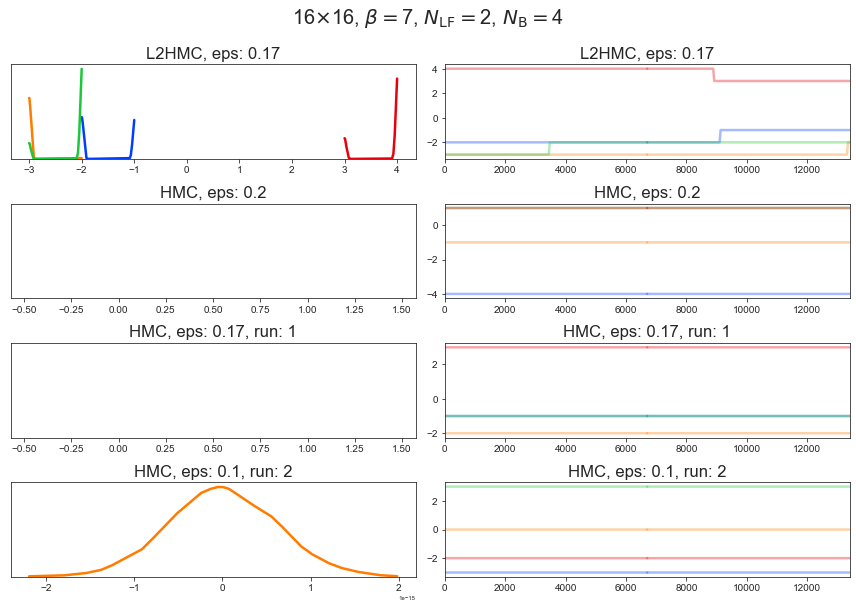

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


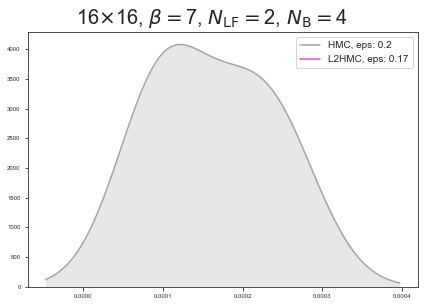

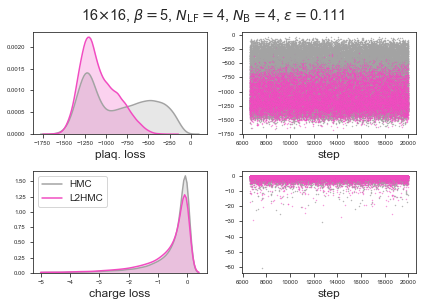

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

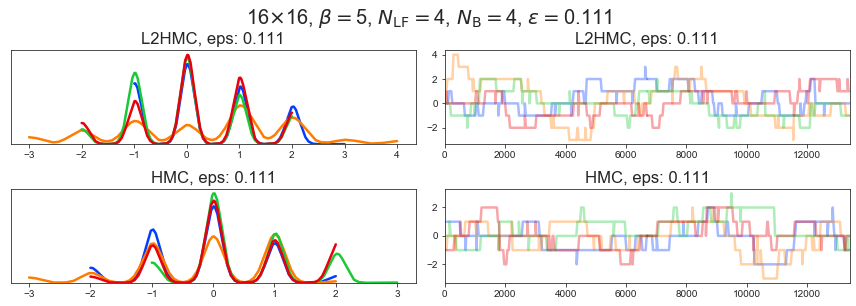

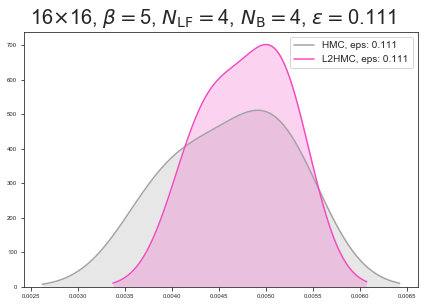

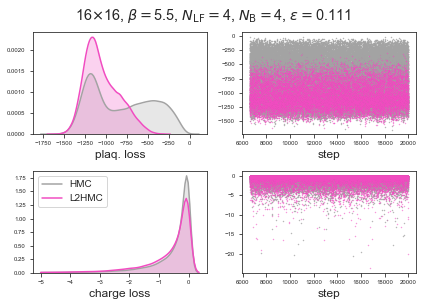

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

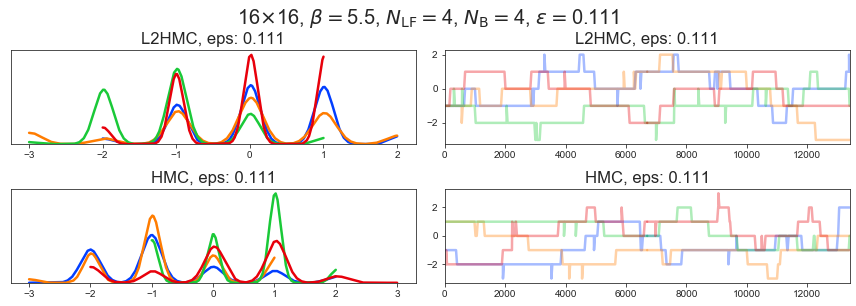

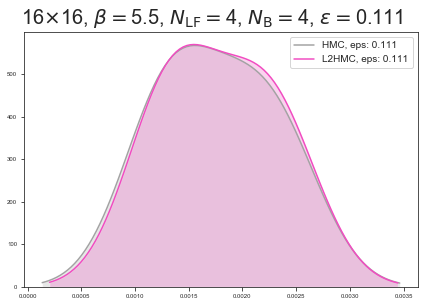

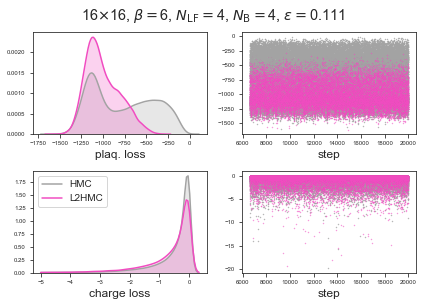

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

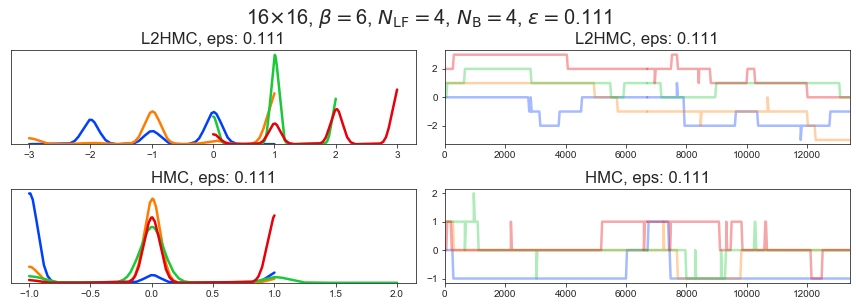

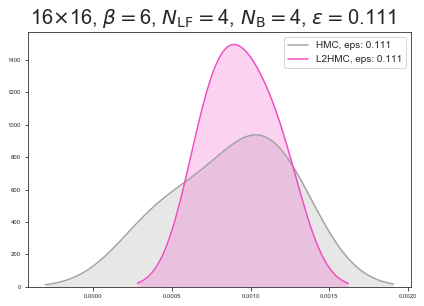

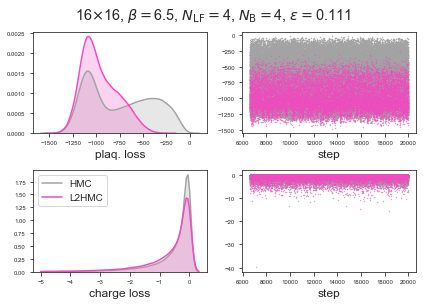

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

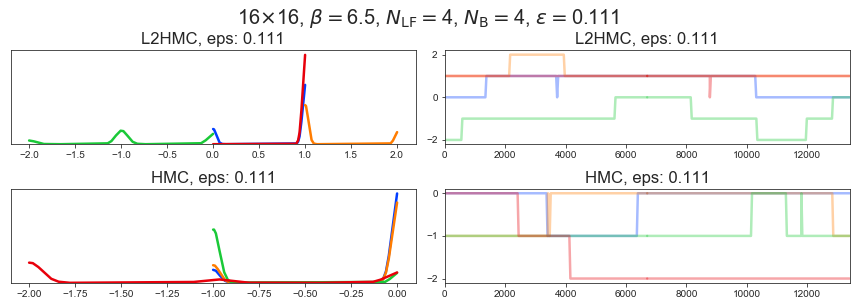

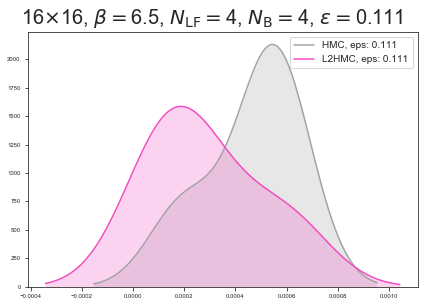

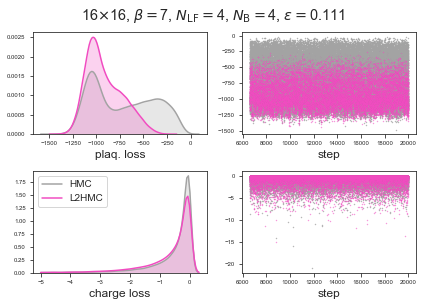

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

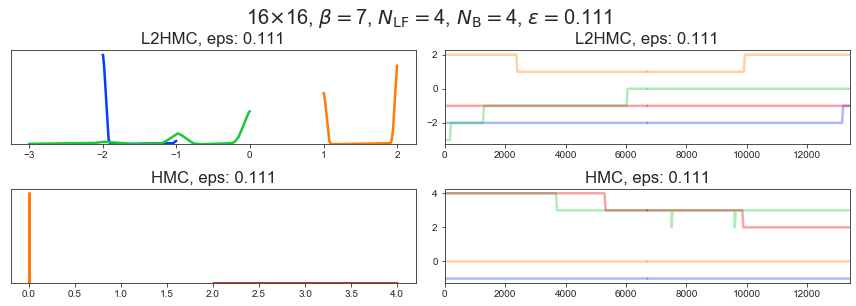

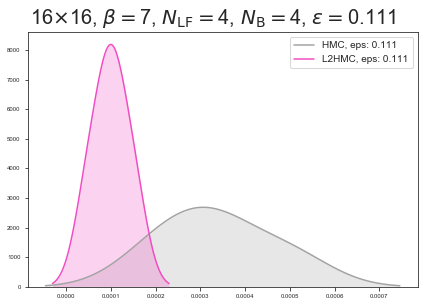

In [28]:
 
#log_dir = os.path.abspath('../../gauge_logs/cooley_logs/2020_05_04/L16_b2048_lf2_GaugeNetwork_aw00_qw01_dp025_f32_1750_1/')
#log_dir = os.path.abspath('../../gauge_logs/2020_05_04/L8_b256_lf2_GaugeNetwork_aw00_qw01_dp025_f32_1801/')
#log_dir = os.path.abspath('../../gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/')
#log_dir = os.path.abspath('../../gauge_logs/gce_logs/2020_05_13/L16_b1024_lf4_GaugeNetwork_aw00_qw01_pw01_dp05_f32_1252/')
log_dirs = [
    os.path.abspath('../../gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_2213_1/'),
    os.path.abspath('../../gauge_logs/cooley_logs/2020_05_13/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp025_f32_1747_1/'),
    os.path.abspath('../../gauge_logs/cooley_logs/2020_05_04/L16_b2048_lf2_GaugeNetwork_aw00_qw01_dp025_f32_1750/'),
    os.path.abspath('../../gauge_logs/2020_05_14/L8_b1024_lf4_GaugeNetwork_aw00_qw01_pw01_dp05_f32_0033'),
    os.path.abspath('../../gauge_logs/gce_logs/2020_05_14/L16_b1024_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_0203/'),
    os.path.abspath('../../gauge_logs/gce_logs/2020_05_13/L16_b1024_lf4_GaugeNetwork_aw00_qw01_pw01_dp05_f32_1252/'),
]
#filter_str = 'beta55'
#filter_strs = ['beta50', 'beta55', 'beta60', 'beta65', 'beta70', 'beta75', 'beta80']
#filter_strs = ['beta75', 'beta80']
#losses_dict = {}
#title_strs = {}
#for fft in [0, 2, 10, 30]:
for log_dir in log_dirs:
    filter_strs = get_unique_betas(log_dir)
    for filter_str in filter_strs:
        try:
            hmc_l, l2hmc_l, ts = plot_pair_losses(log_dir, filter_str)
            plt.show()
        except:
            continue

        plot_charges(log_dir, filter_str) #, include_dq=True)
        plot_tunneling_rates(log_dir, filter_str)
        #fft_arr = [0, 5, 10, 30]
        #for n_fft in fft_arr:
            #try:
            #plot_charges(log_dir, filter_str, fft=n_fft) #, include_dq=True)
            #except:
                #continue

In [32]:
params = plt.rcParams
default_params = plt.rcParamsDefault
changes = {}
for key, val in default_params.items():
    if params[key] != val:
        print(f'{key}:\n'
              f'  original: {val}'
              f'  current: {params[key]}')
        changes[key] = params[key]

agg.path.chunksize:
  original: 0  current: 10000
axes.axisbelow:
  original: line  current: True
axes.edgecolor:
  original: black  current: .15
axes.labelcolor:
  original: black  current: .15
axes.prop_cycle:
  original: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])  current: cycler('color', [(0.00784313725490196, 0.24313725490196078, 1.0), (1.0, 0.48627450980392156, 0.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549), (0.9098039215686274, 0.0, 0.043137254901960784), (0.5450980392156862, 0.16862745098039217, 0.8862745098039215), (0.6235294117647059, 0.2823529411764706, 0.0), (0.9450980392156862, 0.2980392156862745, 0.7568627450980392), (0.6392156862745098, 0.6392156862745098, 0.6392156862745098), (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)])
axes.titlesize:
  original: large  current: 10.0
figure.dpi:
  original: 100.0  current: 72.0
figure.edgecolor:
  original: white

In [33]:
changes

{'agg.path.chunksize': 10000,
 'axes.axisbelow': True,
 'axes.edgecolor': '.15',
 'axes.labelcolor': '.15',
 'axes.prop_cycle': cycler('color', [(0.00784313725490196, 0.24313725490196078, 1.0), (1.0, 0.48627450980392156, 0.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549), (0.9098039215686274, 0.0, 0.043137254901960784), (0.5450980392156862, 0.16862745098039217, 0.8862745098039215), (0.6235294117647059, 0.2823529411764706, 0.0), (0.9450980392156862, 0.2980392156862745, 0.7568627450980392), (0.6392156862745098, 0.6392156862745098, 0.6392156862745098), (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)]),
 'axes.titlesize': 10.0,
 'figure.dpi': 72.0,
 'figure.edgecolor': (1, 1, 1, 0),
 'figure.figsize': [6.0, 4.0],
 'figure.subplot.bottom': 0.125,
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 '

In [343]:
def project_angle(x):
    return x - 2 * np.pi * np.floor((x + np.pi) / (2 * np.pi))

def project_angle_fft(x, n=10):
    """use the fourier series representation `x` to approx `project_angle`.
    note: because `project_angle` suffers a discontinuity, we approximate `x`
    with its fourier series representation in order to have a differentiable
    function when computing the loss.
    args:
        x (array-like): array to be projected.
        n (int): number of terms to keep in fourier series.
    """
    y = np.zeros(x.shape, dtype=x.dtype)
    for n in range(1, n):
        y += (-2 / n) * ((-1) ** n) * np.sin(n * x)
    return y

def calc_charges(plaqs):
    pp = project_angle(plaqs)
    return np.sum(pp, axis=(2, 3)) / (2 * np.pi)

def calc_charges_fft(plaqs, n=0):
    if n == 0:
        #plaqs_proj = np.sin(plaqs)
        plaqs_proj = project_angle(plaqs)
    elif n > 0:
        plaqs_proj = project_angle_fft(plaqs, n)
        
    charges = np.sum(plaqs_proj, axis=(2, 3)) / (2 * np.pi)
    
    return charges

In [345]:
log_dirs = [
    #os.path.abspath('../../gauge_logs/gce_logs/2020_05_14/L16_b1024_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_0203/'),
    #os.path.abspath('../../gauge_logs/gce_logs/2020_05_13/L16_b1024_lf4_GaugeNetwork_aw00_qw01_pw01_dp05_f32_1252/'),
    #os.path.abspath('../../gauge_logs/cooley_logs/2020_05_13/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp025_f32_1747_1/'),
    #os.path.abspath('../../gauge_logs/2020_05_14/L8_b1024_lf4_GaugeNetwork_aw00_qw01_pw01_dp05_f32_0033'),
    #os.path.abspath('../../gauge_logs/cooley_logs/2020_05_04/L16_b2048_lf2_GaugeNetwork_aw00_qw01_dp025_f32_1750/'),
    os.path.abspath('../../gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_2213_1/')
]
for log_dir in log_dirs:
    run_dirs = [os.path.join(log_dir, 'runs_np', i) for i in os.listdir(os.path.join(log_dir, 'runs_np'))]
    for run_dir in run_dirs:
        try:
            plaqs = get_plaqs(run_dir)
        except FileNotFoundError:
            continue
            
        q = calc_charges(plaqs)
        f = os.path.join(run_dir, 'charges.z')
        io.savez(q, f, name=f'charges')
        #n_fft = [0, 5, 10, 30]
        #for n in n_fft:
        #    q = calc_charges_fft(plaqs, n)
        #    f = os.path.join(run_dir, f'charges_fft{n}.z')
        #    io.savez(q, f, name=f'charges_fft{n}')

Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_2213_1/runs_np/lf2_bs8_steps50000_beta55_eps0116_nw111111_initrand__2020_05_15_1456/charges.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_2213_1/runs_np/lf2_bs8_steps50000_beta60_eps0116_nw111111_initrand__2020_05_15_1634/charges.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_2213_1/runs_np/lf2_bs8_steps50000_beta65_eps0116_nw111111_initrand__2020_05_15_1809/charges.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp05_f32_2213_1/runs_np/lf2_bs8_steps50000_beta60_eps0116_nw000000_initrand__2020_05_15_1747/charges.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_14/L16_b2048_lf2_GaugeNetwork

In [193]:
import shutil

def mv_charges(run_dir):
    orig_file = os.path.join(run_dir, 'charges.z')
    new_file = os.path.join(run_dir, 'charges_orig.z')
    shutil.move(orig_file, new_file)



Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_13/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp025_f32_1747_1/runs_np/lf2_bs8_steps20000_beta80_eps0126_nw111111_initrand__2020_05_14_1954/charges_fft30.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_13/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp025_f32_1747_1/runs_np/lf2_bs8_steps20000_beta60_eps0126_nw111111_initrand__2020_05_14_0215/charges_fft30.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_13/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp025_f32_1747_1/runs_np/lf2_bs8_steps20000_beta65_eps0126_nw111111_initrand__2020_05_14_0245/charges_fft30.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_13/L16_b2048_lf2_GaugeNetwork_aw00_qw01_pw01_dp025_f32_1747_1/runs_np/lf2_bs8_steps20000_beta75_eps0126_nw000000_initrand__2020_05_14_2054/charges_fft30.z.
Saving charges to /Users/saforem2/l2hmc-qcd/gauge_logs/cooley_logs/2020_05_1

In [ ]:
shutil.move()

In [181]:
q = calc_charges(plaqs)
q10 = calc_charges_fft(plaqs, 10)
q50 = calc_charges_fft(plaqs, 10)

In [188]:
q50 = calc_charges_fft(plaqs, 50)
q100 = calc_charges_fft(plaqs, 100)

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

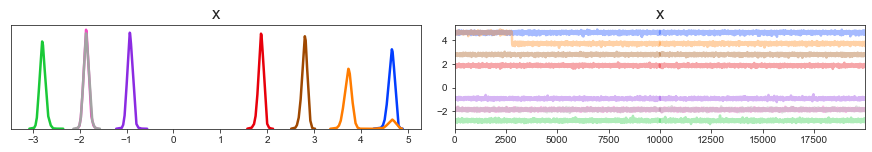

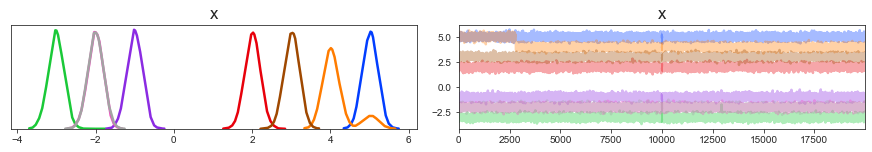

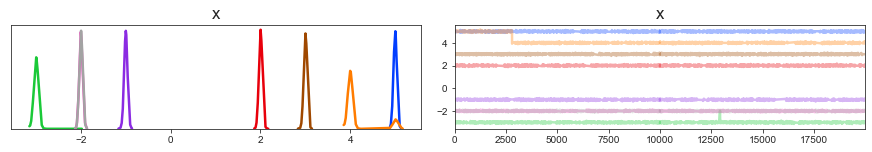

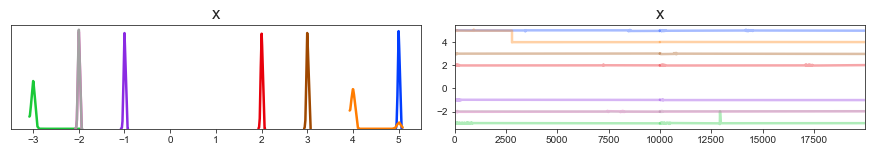

In [189]:
az.plot_trace(q.T)
az.plot_trace(q10.T)
az.plot_trace(q50.T)
az.plot_trace(q100.T)
plt.show()

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

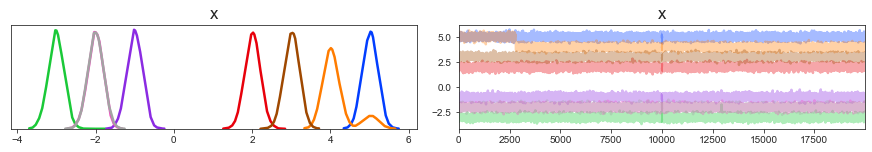

In [186]:
az.plot_trace(q10.T)
plt.show()

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backe

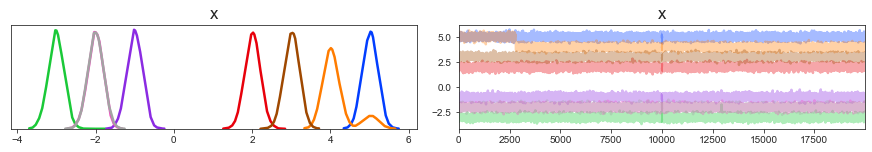

In [187]:
az.plot_trace(q50.T)
plt.show()

In [ ]:
plaqs = get_

In [135]:
ax = axes.get_children()[0]


In [136]:
axes = plt.gca()

In [140]:
axes.texts

[]

In [ ]:
axes.

In [144]:
run_dir = os.path.join(log_dir, 'runs_np', 'lf2_bs3_steps20000_beta50_eps0165_nw000000_rand__2020_05_05_0428')
charges_file = os.path.join(run_dir, 'observables', 'charges.z')
charges = io.loadz(charges_file)

In [145]:
tunn_stats = calc_tunneling_stats(charges)

In [149]:
plt.clf()

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


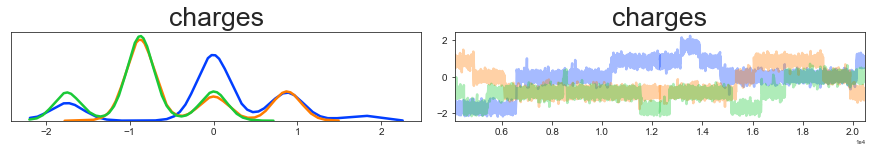

In [153]:
import xarray as xr

q = np.array(charges.T)
arr, steps = therm_arr(np.array(q))
data = {
    'charges': xr.DataArray(arr, dims=['chain', 'draw'],
                            coords=[np.arange(arr.shape[0]), steps])
}
dataset = xr.Dataset(data)
az.plot_trace(dataset)
plt.show()

In [113]:
#log_dir = os.path.abspath('../../gauge_logs/2020_04_28/L12_b128_lf2_GaugeNetwork_aw00_qw01_dp025_f32_0146/')
#log_dir = os.path.abspath('../../gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/')
runs_dir = os.path.join(log_dir, 'runs_np')
run_dirs = io.get_subdirs(runs_dir)
filter_str = 'beta50'
run_dirs = [i for i in run_dirs if filter_str in i and 'mix_samplers' not in i]
run_dirs

['/Users/saforem2/l2hmc-qcd/gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/runs_np/lf2_bs1_steps50000_beta50_eps011_nw111111_rand__2020_04_30_0128',
 '/Users/saforem2/l2hmc-qcd/gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/runs_np/lf2_bs1_steps50000_beta50_eps011_nw111111_rand__2020_04_30_1228',
 '/Users/saforem2/l2hmc-qcd/gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/runs_np/lf2_bs1_steps50000_beta50_eps011_nw000000_rand__2020_04_29_2351',
 '/Users/saforem2/l2hmc-qcd/gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/runs_np/lf2_bs16_steps50000_beta50_eps011_nw111111_rand__2020_04_30_1221',
 '/Users/saforem2/l2hmc-qcd/gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/runs_np/lf2_bs1_steps50000_beta50_eps011_nw111111_rand__2020_04_30_0614',
 '/Users/saforem2/l2hmc-qcd/gauge_logs/2020_04_29/L16_b256_lf2_GaugeNetwork_aw00_qw01_dp05_f32_1427/runs_np/lf2_bs16_steps50000_b

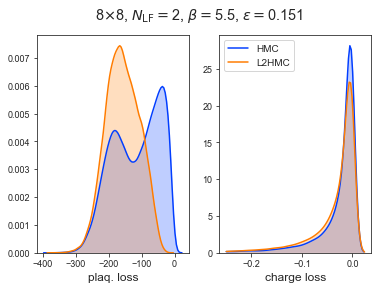

In [59]:
plot_densities(losses_hmc, losses_l2hmc, title_str)
plt.show()

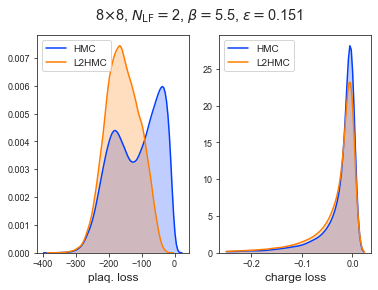

In [ ]:
#filter_strs = ['beta50', 'beta55', 'beta60', 'beta70']
for filter_str in filter_strs:
    plot_pair_losses(log_dir, filter_str)